# Secondary Assists
Our goal with this analysis is to determine if it makes sense to spend money on a player who earns a lot of secondary assists in hockey. Hockey tracks two levels of assists. If Player A passes to Player B who then passes to Player C, who then scores a goal, points are awards as follows:

- Player C - 1 point for the goal
- Player B - 1 point for the primary assist
- Player A - 1 point for the secondary assist

Hockey is one of the only sports to track assists beyond the primary assist, but since we have this data, let's determine if players who are good at it are worth anything.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
%matplotlib inline
%run ./data-loading.ipynb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fetch the common set of player data everyone on the team is working with
player_data = fetch_player_data()

player_data.head()

Team Position  GP          TOI  Goals  Total Assists  \
Year Player                                                               
2015 Jamie Benn     DAL        F  82  1635.733333     35             52   
     John Tavares   NYI        F  82  1695.200000     38             48   
     Sidney Crosby  PIT        F  77  1538.533333     28             56   
     Alex Ovechkin  WSH        F  81  1646.400000     53             28   
     Jakub Voracek  PHI        F  82  1524.633333     22             59   

                    First Assists  Second Assists  Total Points  Shots    SH%  \
Year Player                                                                     
2015 Jamie Benn                32              20            87    253  13.83   
     John Tavares              30              18            86    278  13.67   
     Sidney Crosby             31              25            84    237  11.81   
     Alex Ovechkin             21               7            81    395  13.42   
     Jakub Voracek             31              28            81    221   9.95   

                    Shot Attempts  Hits  Hits Taken  
Year Player                                          
2015 Jamie Benn               466   120         101  
     John Tavares             471    48         103  
     Sidney Crosby            380    66         117  
     Alex Ovechkin            825   259         108  
     Jakub Voracek            424    55         139

### Examining Line of Best Fit 
To start our analysis, let's look at the line of best fit. There are a lot of players in our analysis, so to make this easier, we're going to limit ourselves to only looking at one player per team (for now). We want players who have proven to be good at this skill, so we'll look at the player from each team who scored the most secondary assists in the first year of data that we have (2015).

In [3]:
# We want to find the player with the most secondary assists in the first year of our analysis, 2015
def get_top_assisters_from_year_1(player_data, column):
    # get the first year of data
    first_year_data = player_data[player_data.index.get_level_values(0) == 2015]

    # find the top assister per team
    top_assisters_per_team = first_year_data.groupby("Team")[column].aggregate("max")
    top_assisters = []
    for team, assists in top_assisters_per_team.items():
        team_players = first_year_data["Team"] == team
        secondary_assisters = first_year_data[column] == assists
        player = first_year_data[team_players & secondary_assisters].index.get_level_values(1)[0]
        top_assisters.append(player)
    return top_assisters

In [4]:
def get_player_column_values(player_name, column):
    players_year_data = player_data[player_data.index.get_level_values(1) == player_name]
    return players_year_data[column]

In [5]:
def get_line_of_best_fit(player_yearly_data):
    years = player_yearly_data.index.get_level_values(0)
    second_assists = player_yearly_data.values
    x = sm.add_constant(years)
    result = sm.OLS(second_assists, x).fit()
    intercept, slope = result.params
    return intercept, slope

In [6]:
# get the top assister from each team
top_assisters = get_top_assisters_from_year_1(player_data, "Second Assists")

player_time_series = []
for assister in top_assisters:
    # for each assisters, get their secondary assists in every year
    player_yearly_data = get_player_column_values(assister, "Second Assists")
    # plot their line of best fit, and get the values we need
    intercept, slope = get_line_of_best_fit(player_yearly_data)
    player_time_series.append((intercept, slope, assister))

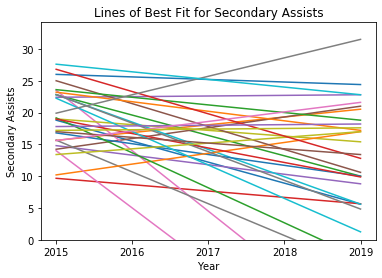

In [7]:
years = player_data.index.get_level_values(0)
# for each of the lines of best fit, let's plot it on our chart
for intercept, slope, assister in player_time_series:
    plt.plot(years, intercept + slope*years, label=f"{assister}")
plt.ylim(bottom=0)
plt.xticks([2015,2016,2017,2018,2019])
plt.ylabel("Secondary Assists")
plt.xlabel("Year")
plt.title("Lines of Best Fit for Secondary Assists")
plt.show()

#### Conclusion
From the above chart we can determine...exactly nothing. Some players got worse over the years, some players got better over the years. Some players look like they retired after a year or two (the lines dropping off the graph). I think we're approaching this from the wrong angle.

### Variance in Goal Scoring Rate
#### Conversion to Rate Stats
There are a few problems with the above study. For one, we're using the raw secondary assists. If a player was injured in one year, their raw totals would see a dip, totally unrelated to their play. As well, if a player falls in to a coach's "bad book" for a while, they may be penalized in ice time, or power play time, which would both lead to drops in raw totals. The first thing we're going to do is to change our raw secondary assists into a rate state based on the amount they played.

#### Looking at Standard Deviation
Once we have switched to rate stats, I think what we want to look at is the variance in those numbers. Assuming that a players skill allows them to get secondary assists, then regardless of everything else (ice time, powerplay, team mates) their rate of scoring secondary assists should be relatively stable. If we graphed the line, it should be fairly flat.

In [8]:
def convert_second_assists_to_rate(row):
    toi, second_assists = row
    return (second_assists/toi)*60

In [9]:
def get_standard_deviations_for_assisters(assisters, skip_nan=True):
    standard_deviations = []
    for assister in assisters:
        # for each assisters, get their secondary assists p60 in every year
        player_sap60_over_time = get_player_column_values(assister, "SA P60")
        std_dev = player_sap60_over_time.std()
        # guard because some players don't have enough data
        if not skip_nan or not np.isnan(std_dev):
            standard_deviations.append(std_dev)
    return standard_deviations

In [10]:
# Add a new column to the data, representing Secondary Assists per 60 minutes of game
player_data["SA P60"] = player_data[["TOI", "Second Assists"]].apply(
    convert_second_assists_to_rate,
    axis=1,
)

In [11]:
# Get the top assisters again, using our new player data, and let's look at the p60 leaders
# instead of raw total leaders
top_assisters = get_top_assisters_from_year_1(player_data, "SA P60")
standard_deviations = get_standard_deviations_for_assisters(top_assisters, skip_nan=False)
zipped_list = zip(top_assisters, standard_deviations)
for player, std_dev in zipped_list:
    print(f"For Assister:\t{player}, their standard deviation was:\t{std_dev}")

For Assister:	Sami Vatanen, their standard deviation was:	0.1991792675367927
For Assister:	Keith Yandle, their standard deviation was:	0.15541924786797223
For Assister:	Ryan Spooner, their standard deviation was:	0.3633051406481594
For Assister:	Zach Bogosian, their standard deviation was:	0.14406253406958636
For Assister:	John-Michael Liles, their standard deviation was:	0.3193531383408899
For Assister:	Brandon Dubinsky, their standard deviation was:	0.26253880596652734
For Assister:	Dennis Wideman, their standard deviation was:	0.2167267466937362
For Assister:	Marian Hossa, their standard deviation was:	0.20567665532902696
For Assister:	Tyson Barrie, their standard deviation was:	0.16850557457858958
For Assister:	Jason Spezza, their standard deviation was:	0.3688160080624835
For Assister:	Johan Franzen, their standard deviation was:	nan
For Assister:	Anton Lander, their standard deviation was:	0.38407120515547527
For Assister:	Jaromir Jagr, their standard deviation was:	0.27104505975

All of these standard deviations seem quite low. Looking at one player, Derrick Brassard, his year over year Secondary Assists P60 numbers were:

| Year | Secondary Assists Per 60 Minutes |
| --- | --- |
| 2015 | 1.077896 |
| 2016 | 0.545143 |
| 2017 | 0.554102 |
| 2018 | 0.281973 |
| 2019 | 0.401976 |

A standard deviation of  of 0.3585 seems like a big number given the values. Assuming he plays 15 minutes per game, over 82 games, that's 1230 minutes, which equates to a difference of about 7.5 secondary assists per year, which is a good chunk of points. It's the difference between Derrick Brassard scoring 50 points one year, and 35 points the next year. That's a huge swing, it's the difference between a player at the bottom your roster, and one closer to the top.

For the really weird numbers above:
- Johan Franzen retired after the first year of data, meaning the variance function failed on him
- Jiri Tlusty was traded mid season in the first year, and then only played a handful of games in his second year before retiring. The small smaples in that first year caused very large numbers, then he retired without points in the second year, causing skewed data.

In [12]:
# Find the average standard deviation across all these players
std_dev_avg = np.average(standard_deviations)
print(f"Average Standard Deviation of these top players: {std_dev_avg}")

Average Standard Deviation of these top players: nan


In [13]:
# Let's see what happens if we expand our study to our entire field of players:
all_assisters = pd.unique(player_data.index.get_level_values(1))
standard_deviations = get_standard_deviations_for_assisters(all_assisters)
std_dev_avg = np.average(standard_deviations)
print(f"Average Standard Deviation of all players: {std_dev_avg}")

Average Standard Deviation of all players: 0.15992548145871077


Interestingly, the standard deviation is lower for all players. I had assumed it would be higher (less good players would see larger swings), but there's a lot of data, so it must average out.

Let's see if there's a difference between forwards and defencemen:

In [14]:
forward_assisters = pd.unique(player_data[player_data["Position"] == "F"].index.get_level_values(1))
standard_deviations = get_standard_deviations_for_assisters(forward_assisters)
std_dev_avg = np.average(standard_deviations)
print(f"Average Standard Deviation of all forwards: {std_dev_avg}")

Average Standard Deviation of all forwards: 0.16448703020237224


In [15]:
defence_assisters = pd.unique(player_data[player_data["Position"] == "D"].index.get_level_values(1))
standard_deviations = get_standard_deviations_for_assisters(defence_assisters)
std_dev_avg = np.average(standard_deviations)
print(f"Average Standard Deviation of all forwards: {std_dev_avg}")

Average Standard Deviation of all forwards: 0.1519743228437179


There is a bit of a difference between forwards and defencemen, but not a tremendous one. It largely mirrors the overall average. Forwards do see more deviation, but not a tremendous amount.

#### Conclusion
We have some data hinting here that secondary assists are not actually repeatable. The data on someone like Derrick Brassard is really helpful because it shows just how big a swing could be. However, I don't think we've concretely proven this for sure.

### Comparing Year over Year Changes 
I want to do one final check on secondary assist scoring rates, and it's based on a suspicion I have. If a player has a certain set of skills that make them good at getting secondary assists, their scoring rate should not change all that much year over year. If we plot a players secondary assist rate per 60m in one year, versus their secondary assist rate the following year, we should see a generally positive trend. 

For example, let's assume a players ability to generate secondary assists is related to their vision and their hand-eye coordination, those are skills that should not be changing much one year to another. I would expect that players that exceed at both of these skills to maintain a high year-over-year scoring rate. Players who are less good at both, or only good at one of those skills would be lower down the graph, and players bad at both skills would maintain a low scoring rate year-over-year.

In order to achieve this, we will need to reshape our data. To keep our study constrained for now, we will use the 2015 season as year 1, and the 2016 season as year 2.

In [16]:
def get_player_secondary_assists_reshaped(name, group):
    secondary_assists_rate = group['SA P60']
    position = group['Position'][0]
    # we want/need data for both of the years
    if len(secondary_assists_rate) != 2:
        return
    return [
        name,
        position,
        secondary_assists_rate[0],
        secondary_assists_rate[1],
   ]

In [17]:
def reshape_data_for_years(year1, year2):
    valid_year_data = player_data[
        (player_data.index.get_level_values(0) == year1) |
        (player_data.index.get_level_values(0) == year2)
    ]
    year_over_year_comparison = []
    data_grouped_by_player = valid_year_data.groupby(level="Player")
    for name, group in data_grouped_by_player:
        reshaped_data = get_player_secondary_assists_reshaped(name, group)
        if reshaped_data:
            year_over_year_comparison.append(reshaped_data)

    reshaped_data = pd.DataFrame(year_over_year_comparison, columns=[
        "Player", "Position", "SAP60_Year1", "SAP60_Year2"
    ])
    reshaped_data = reshaped_data.set_index("Player")
    return reshaped_data

In [18]:
def plot_scatter(reshaped_data):
    ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
    plt.scatter(reshaped_data['SAP60_Year1'], reshaped_data['SAP60_Year2'], marker='.')
    plt.xlabel("Secondary Assists P60 Year 1")
    plt.xticks(ticks)
    plt.ylabel("Secondary Assists P60 Year 2")
    plt.yticks(ticks)
    plt.title("Secondary Assists Year Comparison")
    plt.show()

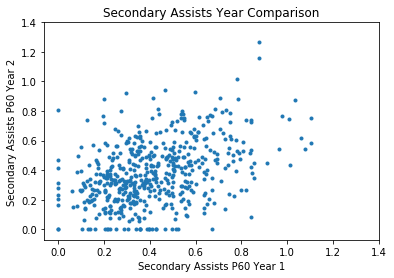

In [19]:
reshaped_data_1516 = reshape_data_for_years(2015, 2016)
plot_scatter(reshaped_data_1516)

Upon looking at this scatter plot, it looks like our assumption was generally true, players who did well one year seem to have done well the following year. Let's find the linear regression.

In [20]:
def get_reshaped_line_of_best_fit(reshaped_data):
    sap60_year1 = reshaped_data['SAP60_Year1']
    sap60_year2 = reshaped_data['SAP60_Year2']
    x = sm.add_constant(sap60_year2)
    result = sm.OLS(sap60_year1, x).fit()
    return result

In [21]:
def plot_scatter_with_lobf(reshaped_data, ols_results):
    intercept, slope = ols_results.params
    sap60_year1 = reshaped_data['SAP60_Year1']
    plt.scatter(reshaped_data['SAP60_Year1'], reshaped_data['SAP60_Year2'], marker='.')
    plt.plot(
        sap60_year1,
        intercept + slope*sap60_year1,
        color="red",
        label=f"RSquared = {round(ols_results.rsquared, 4)}",
    )
    ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
    plt.xlabel("Secondary Assists P60 Year 1")
    plt.xticks(ticks)
    plt.ylabel("Secondary Assists P60 Year 2")
    plt.yticks(ticks)
    plt.title("Secondary Assists Year Comparison")
    plt.legend()
    plt.show()

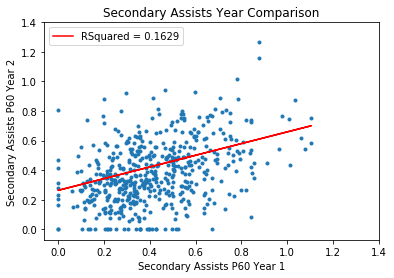

In [22]:
ols_results_1516 = get_reshaped_line_of_best_fit(reshaped_data_1516)
plot_scatter_with_lobf(reshaped_data_1516, ols_results_1516)

#### Analysis
We do indeed have a slightly positive linear regression with an rsquared value of `0.1629`. It is however a very weak relationship. It seems like a bad idea to try to pay the player that was over 0.8 SAP60 only for them to score less than 0.2 SAP60 the following year.

Assuming they play a standard amount of minutes (i.e. 15 per game for 82 games = 1230 minutes)

| Year | Secondary Assists |
| --- | --- |
| 1 | 16.4 |
| 2 | 4.1 |

Either this player lost a 3 quarters of their ability, or the stat is at least partially random noise that we can't rely on. Just to check, let's see what the following years look like.

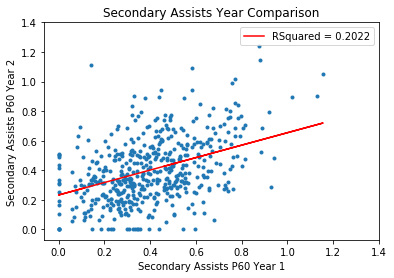

In [23]:
reshaped_data_1617 = reshape_data_for_years(2016, 2017)
ols_results_1617 = get_reshaped_line_of_best_fit(reshaped_data_1617)
plot_scatter_with_lobf(reshaped_data_1617, ols_results_1617)

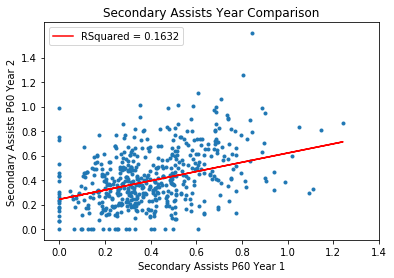

In [24]:
reshaped_data_1718 = reshape_data_for_years(2017, 2018)
ols_results_1718 = get_reshaped_line_of_best_fit(reshaped_data_1718)
plot_scatter_with_lobf(reshaped_data_1718, ols_results_1718)

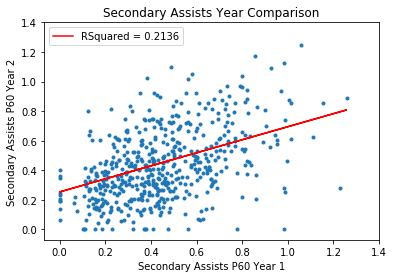

In [25]:
reshaped_data_1819 = reshape_data_for_years(2018, 2019)
ols_results_1819 = get_reshaped_line_of_best_fit(reshaped_data_1819)
plot_scatter_with_lobf(reshaped_data_1819, ols_results_1819)

The story does not really improve in the following years, with the rsquared value always sitting between 0.16 nd 0.21, all very weak relationships.

Just to satisfy my own curiosity, I wonder if there's a difference in position, let's repeat the first year separately for forwards and defencemen.

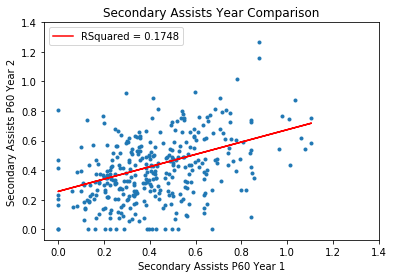

In [26]:
forwards_only_data = reshaped_data_1516[reshaped_data_1516["Position"] == "F"]
ols_results_forwards = get_reshaped_line_of_best_fit(forwards_only_data)
plot_scatter_with_lobf(forwards_only_data, ols_results_forwards)

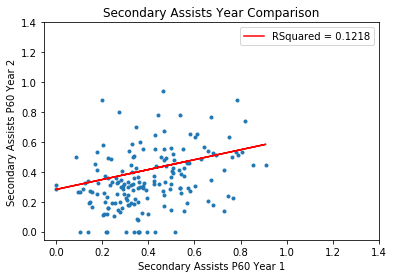

In [27]:
forwards_only_data = reshaped_data_1516[reshaped_data_1516["Position"] == "D"]
ols_results_forwards = get_reshaped_line_of_best_fit(forwards_only_data)
plot_scatter_with_lobf(forwards_only_data, ols_results_forwards)

There is a difference in that defencemen have a lower rsquared value, but it's not a tremendous difference. Both of them are very weak correlations, but the defencemen have an even weaker relationship.

## Conclusion
Overall, it seems like not a particularly good idea to pay a player based on their secondary assists, and we should be wary of secondary assist counts in total points. Using the example of Derrick Brassard* above (who had a standard deviation of almost 7.5 assists per year), paying him to be a second line player based on his 50 points output would be foolish given that the next year he could be closer to a bottom of the roster player with 35 points.

Based on the very weak relationships that secondary assist rates have to each other, what I suspect is that there is some small amount of skill involved in secondary assists, but that more often than not, it is near random noise. 

\* Derrick Brassard is having a bit of career resurgence this year on a new team. His 17 total points only include 4 secondary assists.

## Do Secondary Assists Lead to More Wins


In [28]:
team_data = fetch_team_data()
team_data.head()

Wins  Losses  Overtime Losses  Points  Points %  \
Year Team                                                                   
2015 Anaheim Ducks          51      24                7     109  1.329268   
     Arizona Coyotes        24      50                8      56  0.682927   
     Boston Bruins          41      27               14      96  1.170732   
     Buffalo Sabres         23      51                8      54  0.658537   
     Carolina Hurricanes    30      41               11      71  0.865854   

                         Team Code  
Year Team                           
2015 Anaheim Ducks             ANA  
     Arizona Coyotes           ARI  
     Boston Bruins             BOS  
     Buffalo Sabres            BUF  
     Carolina Hurricanes       CAR

In [29]:
def add_secondary_assists_for_team_and_year(row):
    year = row.name[0]
    team = row["Team Code"]
    year_data = player_data.index.get_level_values(0) == year
    team_data = player_data["Team"] == team
    summed_second_assists = player_data[year_data & team_data]["Second Assists"].aggregate("sum")
    return summed_second_assists

In [30]:
# Add a new column summing the secondary assists per year
team_data["Second Assists"] = team_data.apply(add_secondary_assists_for_team_and_year, axis=1)

In [31]:
team_data.head()

Wins  Losses  Overtime Losses  Points  Points %  \
Year Team                                                                   
2015 Anaheim Ducks          51      24                7     109  1.329268   
     Arizona Coyotes        24      50                8      56  0.682927   
     Boston Bruins          41      27               14      96  1.170732   
     Buffalo Sabres         23      51                8      54  0.658537   
     Carolina Hurricanes    30      41               11      71  0.865854   

                         Team Code  Second Assists  
Year Team                                           
2015 Anaheim Ducks             ANA             154  
     Arizona Coyotes           ARI             126  
     Boston Bruins             BOS             162  
     Buffalo Sabres            BUF             121  
     Carolina Hurricanes       CAR             149

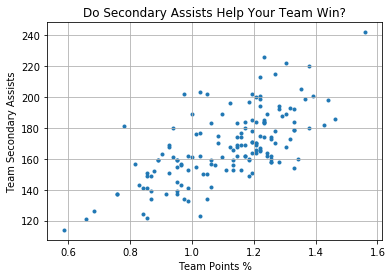

In [32]:
plt.scatter(team_data['Points %'], team_data['Second Assists'], marker='.')
plt.xlabel("Team Points %")
plt.ylabel("Team Secondary Assists")
plt.title("Do Secondary Assists Help Your Team Win?")
plt.grid()
plt.show()

Upon first glance this looks to be a pretty good positive correlation. If we could find players who consistently got secondary assists, it would lead the team to winning more games. Let's find the line of best fit.

In [33]:
team_secondary_assists = team_data['Second Assists']
team_points_perc = team_data['Points %']
x = sm.add_constant(team_points_perc)
result = sm.OLS(team_secondary_assists, x).fit()
intercept, slope = result.params
rsquared = result.rsquared

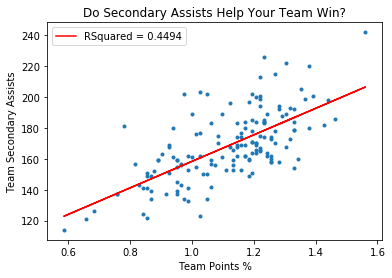

In [34]:
plt.scatter(team_points_perc, team_secondary_assists, marker='.')
plt.plot(
    team_points_perc,
    intercept + slope*team_points_perc,
    color="red",
    label=f"RSquared = {round(rsquared, 4)}",
)
plt.xlabel("Team Points %")
plt.ylabel("Team Secondary Assists")
plt.title("Do Secondary Assists Help Your Team Win?")
plt.legend()
plt.show()

With an rsquared value of 0.45, this is a much stronger relation than players being able to repeat their results. It's also possible there is a confounding variable here though. Each secondary assists is, by definition, tied to a goal, which is how team win games, so what we are probably measuring here is that team's that score more goals win more games (a truly deep analysis).

## Conclusion
To answer the questions posed in the problem statement:

#### Will a player who is good at secondary assists continue to be?

Probably not. There is a very weak positive correlation in year over year results. Players can see sizable swings in their secondary assists, so if our imaginary player has a high occurence of secondary assists, we should be very hesitant to commit large cap space to that player.

#### Will having a player who _is_ good at secondary assists help our team win?

Yes they will. Players who can consistently score secondary assists would help our team win by helping to score goals. Can we find this imaginary player? Probably not. 